# Step 2: Pre-processing - Creating a spatial mask 🗺️

I need to define my region of interest. This region will be converted in a grid to resample the rasters in the resampling step (see the *Resampling* Notebook). Defining a specific region allows me to focus my model on a specific region by applying a geographic mask. It will be very usefull to calculate the annual mean of the Wave dataset (See the *Calculating_annual_mean* Notebook). You can filter datasets using geometries, which can range from simple polygons to more complex ones that include multiple polygons or holes.

For my example, I downloaded the geometries of **Skagerrak**, **Kattegat**, and the **Sweden Exclusive Economic Zone (EEZ)** from the [Marine Regions website](https://marineregions.org) in **.JSON** format:

- 🔗 [Sweden EEZ](https://www.marineregions.org/gazetteer.php?p=details&id=5694)
- 🔗 [Kattegat](https://marineregions.org/gazetteer.php?p=details&id=2374)
- 🔗 [Skagerrak](https://www.marineregions.org/gazetteer.php/gazetteer.php?p=details&id=2379)

Once you have clicked on "dowload", just **right click** on the new web page to save the file in a **.JSON** format.

I intend to cover the entire **Sweden EEZ** for the final model. However, to save time in the development process, I will first focus on a smaller region: the **Living Lab West**. This means I will combine the geometries of **Kattegat** and **Skagerrak**, and then filter this combined geometry using the **Sweden EEZ** geometry.

#### 📚 Required Libraries 
To perform this spatial filtering, you will need the following libraries:
- **`geopandas`**: For reading and manipulating spatial data.
- **`pandas`**: For reading, manipulating, and analyzing the data. 
- **`shapely`**: For geometric operations like union and intersection. 
- **`matplotlib`**: For visualizing the data. 


### 🛠️ Steps 
**Create the mask**: Load and combine the geometries, filter with the Sweden EEZ geometry and visualize the filtered geometry
____


### 🛠️ Create the mask

In [1]:
import geopandas as gpd

In [2]:
# Load the geometries from the .json files
sweden_eez = gpd.read_file('data/sweden_eez.json')
kattegat = gpd.read_file('data/kattegat.json')
skagerrak = gpd.read_file('data/skagerrak.json')


💡 Make sure the CRS (Coordinate Reference System) is the same for all datasets. If needed, you can reproject them to the same CRS. For example :

`sweden_eez = sweden_eez.to_crs(epsg=4326)`

C:\Users\PC\AppData\Local\Temp\ipykernel_22720\1839412773.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union


<Axes: >

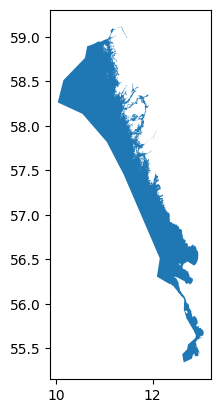

In [3]:
# Combine Kattegat and Skagerrak geometries
combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union 

# Filter the combined geometry using the Sweden EEZ
filtered_geometry = sweden_eez.geometry.intersection(combined_geometry)

# Create a new GeoDataFrame with the filtered geometry
filtered_gdf = gpd.GeoDataFrame(geometry=filtered_geometry)

# Save the result to a new .json file
filtered_gdf.to_file('data/livinglab_west.json', driver='GeoJSON')

# Visualize the result
filtered_gdf.plot()

### 🛠️ Filtering the Zosteraceae dataset

In [4]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
# Load the livinglab west geometry from the GeoJSON file
livinglab_geometry = gpd.read_file('livinglab_west.json')

In [6]:
# Load the Artportalen CSV file into a pandas DataFrame
df = pd.read_csv('data/00_raw_Zosteraceae.csv', delimiter ='\t')
print(df.columns)

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')


💡 The spatial delimiter of the Artportalen dataset is a tab. 

I printed the columns of the dataframe to identify the longitude and latitude columns names: `'decimalLatitude'` and `'decimalLongitude'`

In [7]:
# Define the geometry using longitude and latitude columns
points = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]

# Convert the dataframe to a GeoDataFrame 
gdf_plants = gpd.GeoDataFrame(df, geometry=points)

# Make sure the CRS of Artportalen-Zosteraceae.csv matches the CRS of livinglab_ouest.json
gdf_plants = gdf_plants.set_crs('EPSG:4326', allow_override=True)

# Filter the points within the 'livinglab_ouest' geometry
filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]

# Save the filtered data or work with it directly
filtered_gdf_plants.to_csv('data/01_filtered_Zosteraceae.csv', index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_22720\1781516550.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]


In [8]:
filtered_gdf_plants.geometry

0       POINT (11.89793 58.20742)
3       POINT (12.15456 57.32701)
4       POINT (11.84955 58.25391)
5       POINT (11.12229 58.87922)
8       POINT (11.56968 58.32986)
                  ...            
1903    POINT (12.53908 56.21715)
1904    POINT (12.91785 56.46712)
1909    POINT (11.78615 58.32873)
1910    POINT (11.76482 58.02897)
1912    POINT (12.93752 56.58907)
Name: geometry, Length: 1282, dtype: geometry

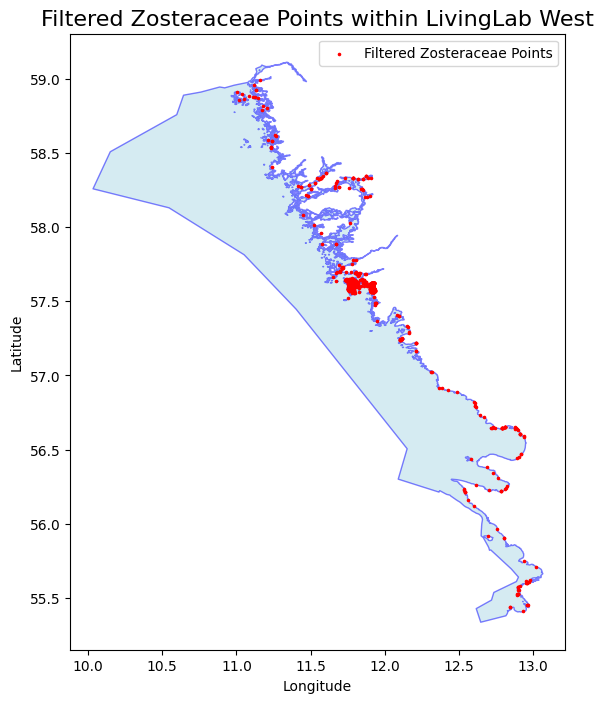

In [9]:
filtered_gdf_plants = pd.read_csv('data/01_filtered_Zosteraceae.csv')
filtered_gdf_plants = gpd.GeoDataFrame(filtered_gdf_plants, 
                                       geometry=gpd.points_from_xy(filtered_gdf_plants['decimalLongitude'], 
                                                                   filtered_gdf_plants['decimalLatitude']
                                                                   )
                                        )

# Plot the polygon and the filtered points
fig, ax = plt.subplots(figsize=(8, 8))
livinglab_geometry.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)
filtered_gdf_plants.plot(ax=ax, marker='.', color='red', markersize=10, label="Filtered Zosteraceae Points")
ax.set_title('Filtered Zosteraceae Points within LivingLab West', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()